In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# 체스보드 이미지를 비디오에서 선택하는 함수
def select_img_from_video(video_file, board_pattern, select_all=False, wait_msec=10, wnd_name='Camera Calibration'):
    # 비디오 파일 열기
    video = cv.VideoCapture("C:\\SJS\\ACV\\4hw\\chessboard.mp4")
    assert video.isOpened(), "비디오 파일을 열 수 없습니다."

    # 선택된 이미지를 저장할 리스트
    img_select = []
    while True:
        # 비디오에서 프레임 읽기
        valid, img = video.read()
        if not valid:
            break

        if select_all:
            img_select.append(img)
        else:
            # 이미지 표시
            display = img.copy()
            cv.putText(display, f'NSelect: {len(img_select)}', (10, 25), cv.FONT_HERSHEY_DUPLEX, 0.6, (0, 255, 0))
            cv.imshow(wnd_name, display)

            # 키 입력 처리
            key = cv.waitKey(wait_msec)
            if key == ord(' '):  # 스페이스바: 일시 정지 및 코너 찾기
                complete, pts = cv.findChessboardCorners(img, board_pattern)
                cv.drawChessboardCorners(display, board_pattern, pts, complete)
                cv.imshow(wnd_name, display)
                key = cv.waitKey()
                if key == ord('\r'):  # 엔터: 이미지 선택
                    img_select.append(img)
            if key == 27:  # ESC: 종료
                break

    cv.destroyAllWindows()
    return img_select


In [2]:
# 카메라 캘리브레이션 함수
def calib_camera_from_chessboard(images, board_pattern, board_cellsize, K=None, dist_coeff=None, calib_flags=None):
    # 이미지에서 2D 코너 포인트 찾기
    img_points = []
    for img in images:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        complete, pts = cv.findChessboardCorners(gray, board_pattern)
        if complete:
            img_points.append(pts)
    assert len(img_points) > 0, "체스보드 코너가 감지된 이미지가 없습니다."

    # 3D 체스보드 포인트 준비
    obj_pts = [[c, r, 0] for r in range(board_pattern[1]) for c in range(board_pattern[0])]
    obj_points = [np.array(obj_pts, dtype=np.float32) * board_cellsize] * len(img_points)  # 3D 포인트

    # 카메라 캘리브레이션 수행
    return cv.calibrateCamera(obj_points, img_points, gray.shape[::-1], K, dist_coeff, flags=calib_flags)


In [6]:
# 왜곡되지 않은 이미지를 반환하는 함수
def undistort_image(img, K, dist_coeff):
    return cv.undistort(img, K, dist_coeff)

In [4]:
# 카메라 포즈 시각화 함수
def visualize_camera_poses(rvecs, tvecs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for rvec, tvec in zip(rvecs, tvecs):
        R, _ = cv.Rodrigues(rvec)
        ax.quiver(tvec[0], tvec[1], tvec[2], R[0, 0], R[1, 0], R[2, 0], color='r')
        ax.quiver(tvec[0], tvec[1], tvec[2], R[0, 1], R[1, 1], R[2, 1], color='g')
        ax.quiver(tvec[0], tvec[1], tvec[2], R[0, 2], R[1, 2], R[2, 2], color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


## 카메라 캘리브레이션 결과
* 선택된 이미지 수 = 8
* RMS 에러 = 0.6122347908567354
* 카메라 행렬 (K) = 
[[1.10452907e+03 0.00000000e+00 6.26232505e+02]
 [0.00000000e+00 1.10591976e+03 3.70163770e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
* 왜곡 계수 (k1, k2, p1, p2, k3, ...) = [ 0.22812599 -0.95568262  0.00608845 -0.00767726  1.20319716]


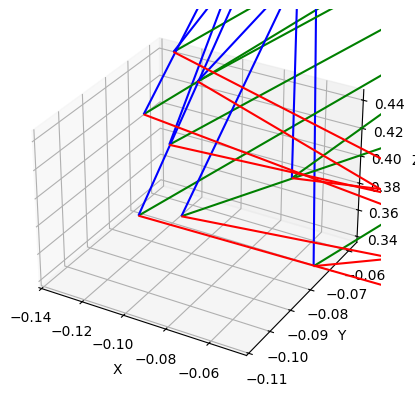

In [8]:
# 메인 함수
if __name__ == '__main__':
    video_file = "C:\\SJS\\ACV\\4hw\\chessboard.mp4"  # 비디오 파일 경로
    board_pattern = (10, 7)  # 체스보드 패턴 (가로, 세로 코너 개수)
    board_cellsize = 0.025  # 체스보드 셀 크기 (미터)

    # 비디오에서 체스보드 이미지를 선택
    img_select = select_img_from_video(video_file, board_pattern)
    assert len(img_select) > 0, '선택된 이미지가 없습니다!'

    # 선택된 이미지를 바탕으로 카메라 캘리브레이션 수행
    rms, K, dist_coeff, rvecs, tvecs = calib_camera_from_chessboard(img_select, board_pattern, board_cellsize)

    # 캘리브레이션 결과 출력
    print('## 카메라 캘리브레이션 결과')
    print(f'* 선택된 이미지 수 = {len(img_select)}')
    print(f'* RMS 에러 = {rms}')
    print(f'* 카메라 행렬 (K) = \n{K}')
    print(f'* 왜곡 계수 (k1, k2, p1, p2, k3, ...) = {dist_coeff.flatten()}')

    # 선택 사항: 왜곡되지 않은 이미지 출력
    undistorted_img = undistort_image(img_select[0], K, dist_coeff)
    cv.imshow('Undistorted Image', undistorted_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    # 선택 사항: 카메라 포즈 시각화
    visualize_camera_poses(rvecs, tvecs)